# Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
import numpy as np
import sklearn as sk
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

# check Tensorflow version
print(tf.version.VERSION)

2.8.0


# A few tricks to make Tensorflow Datasets work

In [2]:
# !pip install tensorflow_datasets ipywidgets

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Prepare the Orchid-52 dataset

In [4]:
builder = tfds.folder_dataset.ImageFolder('orchid/')
print(builder.info)

train_ds = builder.as_dataset(split='train', shuffle_files=True)
valid_ds = builder.as_dataset(split='valid', shuffle_files=False)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='orchid/',
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=52),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=2403, num_shards=1>,
        'valid': <SplitInfo num_examples=780, num_shards=1>,
    },
    citation="""""",
)


# Show a few examples from the training set

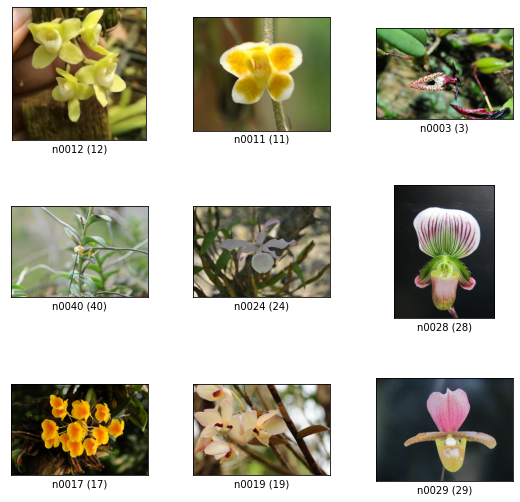

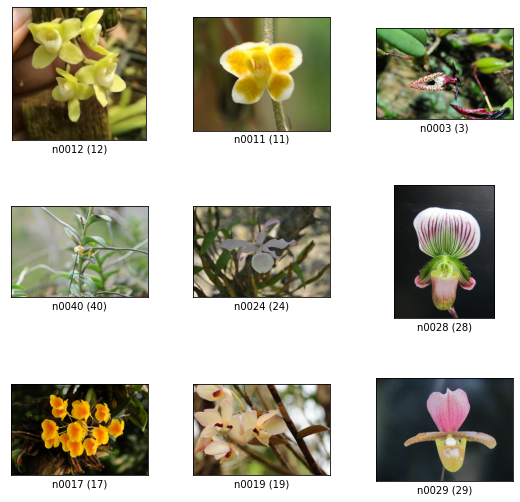

In [5]:
tfds.show_examples(train_ds, builder.info)

# Preprocess the images

In [6]:
def process_image(example):
    image, label = example['image'], example['label']
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images to 224x224
    image = tf.image.resize(image, (224,224))
    return image, label

In [7]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
valid_ds_size = tf.data.experimental.cardinality(valid_ds).numpy()
print("Training data size:", train_ds_size)
print("Validation data size:", valid_ds_size)

Training data size: 2403
Validation data size: 780


# Prepare batches of data

In [8]:
BATCH_SIZE = 32
train_ds = (train_ds
                  .map(process_image)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=BATCH_SIZE, drop_remainder=True))

valid_ds = (valid_ds
                  .map(process_image)
                  .batch(batch_size=BATCH_SIZE, drop_remainder=False))

# Recreate the model and load best weights

In [9]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_52c/resnet_0_50e.h5')
y_pred = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
y = np.concatenate([y for x, y in valid_ds], axis=0)

y = y.astype(int)
y_pred = y_pred.astype(int)

print(y_pred.shape, y.shape)

25/25 - 166s - 166s/epoch - 7s/step
(780,) (780,)


In [10]:
(precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
conf_mat = confusion_matrix(y, y_pred)

print((precision, recall, fscore, support))

(0.7692307692307693, 0.7692307692307693, 0.7692307692307693, None)


In [11]:
y_pred[:10]

array([32, 44, 13, 13, 31, 48, 32,  7, 44, 27])

In [12]:
y[:10]

array([32, 44, 13,  4, 31, 48, 32,  7, 44, 27])

In [13]:
conf_mat[:15,:15]

array([[12,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  2,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  1,  7,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1, 12,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0

In [58]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_52c/resnet_0_50e.h5')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

# Show the model architecture
# model.summary()

25/25 - 169s - loss: 0.9673 - sparse_categorical_accuracy: 0.7692 - 169s/epoch - 7s/step
Trained model, accuracy: 76.92%


In [60]:
# Loads the weights
model.load_weights('train_52c/training_resnet_0/cp-0025.ckpt')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Best weights trained model, accuracy: {:5.2f}%".format(100 * acc))

25/25 - 165s - loss: 0.9310 - sparse_categorical_accuracy: 0.7538 - 165s/epoch - 7s/step
Best weights trained model, accuracy: 75.38%


In [61]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_52c/densenet_0_50e.h5')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

# Show the model architecture
# model.summary()

25/25 - 83s - loss: 0.4399 - sparse_categorical_accuracy: 0.8974 - 83s/epoch - 3s/step
Trained model, accuracy: 89.74%


In [62]:
# Loads the weights
model.load_weights('train_52c/training_densenet_0/cp-0048.ckpt')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Best weights trained model, accuracy: {:5.2f}%".format(100 * acc))

25/25 - 81s - loss: 0.4010 - sparse_categorical_accuracy: 0.9000 - 81s/epoch - 3s/step
Best weights trained model, accuracy: 90.00%


# Evaluate ResNet on Orchid 52 classes

In [11]:
y_pred = np.array([])
y = np.array([])

for i in range(3):
    # Recreate the exact same model, including its weights and the optimizer
    model = tf.keras.models.load_model(f'train_52c/resnet_{i}_50e.h5')
    y_pred_temp = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    y_pred = np.concatenate((y_pred, y_pred_temp))
    y_temp = np.concatenate([y for x, y in valid_ds], axis=0)
    y = np.concatenate((y, y_temp))

y = y.astype(int)
y_pred = y_pred.astype(int)

print(y_pred.shape, y.shape)

25/25 - 170s - 170s/epoch - 7s/step
25/25 - 170s - 170s/epoch - 7s/step
25/25 - 172s - 172s/epoch - 7s/step
(2340,) (2340,)


In [18]:
(precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
conf_mat = confusion_matrix(y, y_pred)

print((precision, recall, fscore, support))

(0.7547008547008547, 0.7547008547008547, 0.7547008547008548, None)


In [19]:
def vectorize(labels, num_classes):
    """Return a 2-dimensional tensor with the second vector
    consisting of 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere. This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    result = np.zeros((len(labels), num_classes, 1), dtype=np.uint8)
    for i in range(len(labels)):
        j = labels[i]
        result[i, j] = 1
    return result

![Metrics](metrics.png)

In [20]:
actual = vectorize(y, np.max(y)+1)
predicted = vectorize(y_pred, np.max(y)+1)

TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FN + TN + FP)
specificity = TN / (TN + FP)

print(precision, recall, f1, accuracy, specificity)

tf.Tensor(0.7547008547008547, shape=(), dtype=float64) tf.Tensor(0.7547008547008547, shape=(), dtype=float64) tf.Tensor(0.7547008547008548, shape=(), dtype=float64) tf.Tensor(0.9905654174884944, shape=(), dtype=float64) tf.Tensor(0.9951902128372717, shape=(), dtype=float64)


# Evaluate DenseNet on Orchid 52 classes

In [21]:
y_pred = np.array([])
y = np.array([])

for i in range(3):
    # Recreate the exact same model, including its weights and the optimizer
    model = tf.keras.models.load_model(f'train_52c/densenet_{i}_50e.h5')
    y_pred_temp = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    y_pred = np.concatenate((y_pred, y_pred_temp))
    y_temp = np.concatenate([y for x, y in valid_ds], axis=0)
    y = np.concatenate((y, y_temp))

y = y.astype(int)
y_pred = y_pred.astype(int)

print(y_pred.shape, y.shape)

25/25 - 85s - 85s/epoch - 3s/step
25/25 - 86s - 86s/epoch - 3s/step
25/25 - 84s - 84s/epoch - 3s/step
(2340,) (2340,)


In [22]:
(precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
conf_mat = confusion_matrix(y, y_pred)

print((precision, recall, fscore, support))

(0.885042735042735, 0.885042735042735, 0.885042735042735, None)


In [23]:
actual = vectorize(y, np.max(y)+1)
predicted = vectorize(y_pred, np.max(y)+1)

TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FN + TN + FP)
specificity = TN / (TN + FP)

print(precision, recall, f1, accuracy, specificity)

tf.Tensor(0.885042735042735, shape=(), dtype=float64) tf.Tensor(0.885042735042735, shape=(), dtype=float64) tf.Tensor(0.885042735042735, shape=(), dtype=float64) tf.Tensor(0.9955785667324129, shape=(), dtype=float64) tf.Tensor(0.9977459359812301, shape=(), dtype=float64)


# Prepare the Orchid-219 dataset

In [24]:
builder = tfds.folder_dataset.ImageFolder('training/')
print(builder.info)

train_ds = builder.as_dataset(split='train', shuffle_files=True)
valid_ds = builder.as_dataset(split='valid', shuffle_files=False)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='training/',
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=219),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=1533, num_shards=1>,
        'valid': <SplitInfo num_examples=657, num_shards=1>,
    },
    citation="""""",
)


# Show a few examples from the training set

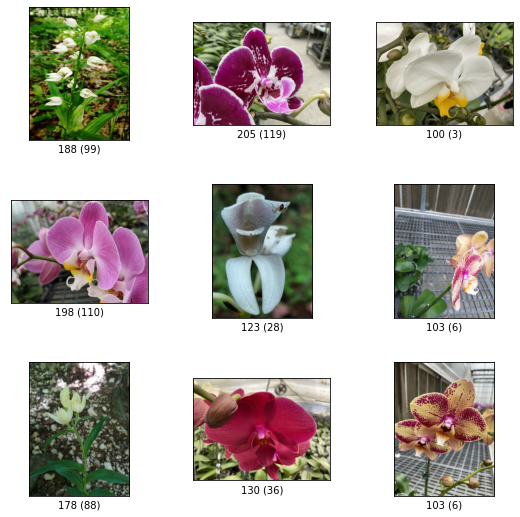

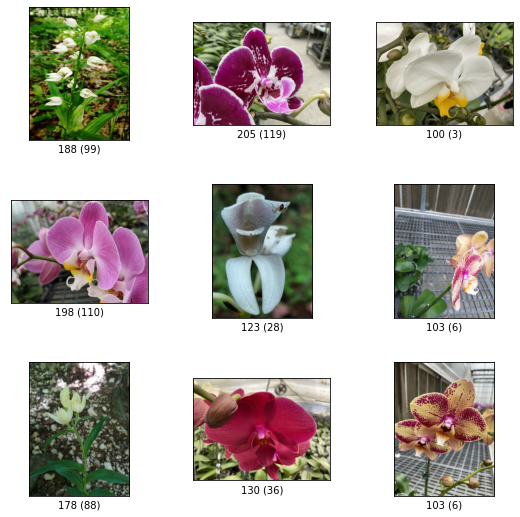

In [25]:
tfds.show_examples(train_ds, builder.info)

# Preprocess the images

In [26]:
def process_image(example):
    image, label = example['image'], example['label']
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images to 224x224
    image = tf.image.resize(image, (224,224))
    return image, label

In [27]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
valid_ds_size = tf.data.experimental.cardinality(valid_ds).numpy()
print("Training data size:", train_ds_size)
print("Validation data size:", valid_ds_size)

Training data size: 1533
Validation data size: 657


# Prepare batches of data

In [28]:
BATCH_SIZE = 32
train_ds = (train_ds
                  .map(process_image)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=BATCH_SIZE, drop_remainder=True))

valid_ds = (valid_ds
                  .map(process_image)
                  .batch(batch_size=BATCH_SIZE, drop_remainder=False))

# Recreate the model and load best weights

In [46]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_219c/resnet_0_219c_50e.h5')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

# Show the model architecture
# model.summary()

21/21 - 140s - loss: 3.5399 - sparse_categorical_accuracy: 0.2435 - 140s/epoch - 7s/step
Trained model, accuracy: 24.35%


In [47]:
# Loads the weights
model.load_weights('train_219c/training_resnet_219c_0/cp-0046.ckpt')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Best weights trained model, accuracy: {:5.2f}%".format(100 * acc))

21/21 - 139s - loss: 3.4727 - sparse_categorical_accuracy: 0.2618 - 139s/epoch - 7s/step
Best weights trained model, accuracy: 26.18%


In [48]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_219c/densenet_0_219c_50e.h5')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

# Show the model architecture
# model.summary()

21/21 - 69s - loss: 2.4972 - sparse_categorical_accuracy: 0.3973 - 69s/epoch - 3s/step
Trained model, accuracy: 39.73%


In [49]:
# Loads the weights
model.load_weights('train_219c/training_densenet_219c_0/cp-0049.ckpt')

# Evaluate the model
loss, acc = model.evaluate(valid_ds, verbose=2)
print("Best weights trained model, accuracy: {:5.2f}%".format(100 * acc))

21/21 - 64s - loss: 2.4609 - sparse_categorical_accuracy: 0.4033 - 64s/epoch - 3s/step
Best weights trained model, accuracy: 40.33%


# Evaluate ResNet on Orchid 219 classes

In [29]:
y_pred = np.array([])
y = np.array([])

for i in range(3):
    # Recreate the exact same model, including its weights and the optimizer
    model = tf.keras.models.load_model(f'train_219c/resnet_{i}_219c_50e.h5')
    y_pred_temp = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    y_pred = np.concatenate((y_pred, y_pred_temp))
    y_temp = np.concatenate([y for x, y in valid_ds], axis=0)
    y = np.concatenate((y, y_temp))

y = y.astype(int)
y_pred = y_pred.astype(int)

print(y_pred.shape, y.shape)

21/21 - 137s - 137s/epoch - 7s/step
21/21 - 136s - 136s/epoch - 6s/step
21/21 - 139s - 139s/epoch - 7s/step
(1971,) (1971,)


In [30]:
(precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
conf_mat = confusion_matrix(y, y_pred)

print((precision, recall, fscore, support))

(0.24099441907661084, 0.24099441907661084, 0.24099441907661084, None)


In [31]:
actual = vectorize(y, np.max(y)+1)
predicted = vectorize(y_pred, np.max(y)+1)

TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FN + TN + FP)
specificity = TN / (TN + FP)

print(precision, recall, f1, accuracy, specificity)

tf.Tensor(0.24099441907661084, shape=(), dtype=float64) tf.Tensor(0.24099441907661084, shape=(), dtype=float64) tf.Tensor(0.24099441907661084, shape=(), dtype=float64) tf.Tensor(0.993068442183348, shape=(), dtype=float64) tf.Tensor(0.9965183230232872, shape=(), dtype=float64)


# Evaluate DenseNet on Orchid 219 classes

In [34]:
y_pred = np.array([])
y = np.array([])

for i in range(3):
    # Recreate the exact same model, including its weights and the optimizer
    model = tf.keras.models.load_model(f'train_219c/densenet_{i}_219c_50e.h5')
    y_pred_temp = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    y_pred = np.concatenate((y_pred, y_pred_temp))
    y_temp = np.concatenate([y for x, y in valid_ds], axis=0)
    y = np.concatenate((y, y_temp))

y = y.astype(int)
y_pred = y_pred.astype(int)

print(y_pred.shape, y.shape)

21/21 - 66s - 66s/epoch - 3s/step
21/21 - 66s - 66s/epoch - 3s/step
21/21 - 66s - 66s/epoch - 3s/step
(1971,) (1971,)


In [35]:
(precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
conf_mat = confusion_matrix(y, y_pred)

print((precision, recall, fscore, support))

(0.4104515474378488, 0.4104515474378488, 0.4104515474378488, None)


In [36]:
actual = vectorize(y, np.max(y)+1)
predicted = vectorize(y_pred, np.max(y)+1)

TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + FN + TN + FP)
specificity = TN / (TN + FP)

print(precision, recall, f1, accuracy, specificity)

tf.Tensor(0.4104515474378488, shape=(), dtype=float64) tf.Tensor(0.4104515474378488, shape=(), dtype=float64) tf.Tensor(0.4104515474378488, shape=(), dtype=float64) tf.Tensor(0.9946159958670123, shape=(), dtype=float64) tf.Tensor(0.9972956493001737, shape=(), dtype=float64)
